In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import io


from src.utils.file import get_data_file_path 

#%load_ext autoreload

In [182]:
# Experiment 1: Fix events n, increase formulas n, to have (accuracy, precision, recall, f1) for each model, draw line chart 
# Experiment 2: Fix formulas n, increase events n, to have (accuracy, precision, recall, f1) for each model, draw line chart

# Data Presentation

In [183]:
path = get_data_file_path(event_n=3, formula_n=3, count=300)
data = pd.read_csv(path)

In [184]:
data.head()

,context,query,question,code,formula,answer,graph
0,"Initially, event3 happened. After event1, even...",C1: Event1 happens or event2 happens.\nC2: C1 ...,"=== Context ===\n\nInitially, event3 happened....","MODULE main\nVAR\n state : {event1, event2,...",(X ((event1 | event2) & event1)),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
1,"Initially, event1 happened. After event3, no o...",C1: Event2 will happen eventually.\nC2: That e...,"=== Context ===\n\nInitially, event1 happened....","MODULE main\nVAR\n state : {event1, event2,...",(G (event2 -> (F event2))),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
2,"Initially, event2 happened. After event2, even...",C1: Event3 will happen at next time.\nC2: Even...,"=== Context ===\n\nInitially, event2 happened....","MODULE main\nVAR\n state : {event1, event2,...",((X event3) -> (X event3)),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
3,"Initially, event3 happened. After event1, even...",C1: Event2 happens and event3 happens.\nC2: Ev...,"=== Context ===\n\nInitially, event3 happened....","MODULE main\nVAR\n state : {event1, event2,...",(! (event1 | (event2 & event3))),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
4,"Initially, event2 happened. After event1, even...",C1: Event3 happens or event3 happens.\nC2: C1 ...,"=== Context ===\n\nInitially, event2 happened....","MODULE main\nVAR\n state : {event1, event2,...",(! ((event3 | event3) | event1)),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."


In [185]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   context   300 non-null    object
 1   query     300 non-null    object
 2   question  300 non-null    object
 3   code      300 non-null    object
 4   formula   300 non-null    object
 5   answer    300 non-null    bool  
 6   graph     300 non-null    object
dtypes: bool(1), object(6)
memory usage: 14.5+ KB


In [186]:
# Context
print(data.loc[0, 'context'])

Initially, event3 happened. After event1, event2 will happen. After event2, event1 will happen. After event3, event1 will happen.


In [187]:
# Query 
print(data.loc[0, 'query'])

C1: Event1 happens or event2 happens.
C2: C1 holds and event1 happens.
C3: C2 will happen at next time.


In [188]:
# Question
print(data.loc[0, 'question'])

=== Context ===

Initially, event3 happened. After event1, event2 will happen. After event2, event1 will happen. After event3, event1 will happen.

=== Hypothesis ===

C1: Event1 happens or event2 happens.
C2: C1 holds and event1 happens.
C3: C2 will happen at next time.

C3 is True or False? Answer with "True" or "False" directly:



In [189]:
# Code
print(data.loc[0, 'code'])

MODULE main
VAR
    state : {event1, event2, event3};
ASSIGN
    init(state) := event3;
    next(state) := case
        state = event1 : event2;
		state = event2 : event1;
		state = event3 : event1;
    esac;
LTLSPEC (X (((state=event1) | (state=event2)) & (state=event1)))



In [190]:
# Formula
print(data.loc[0, 'formula'])

(X ((event1 | event2) & event1))


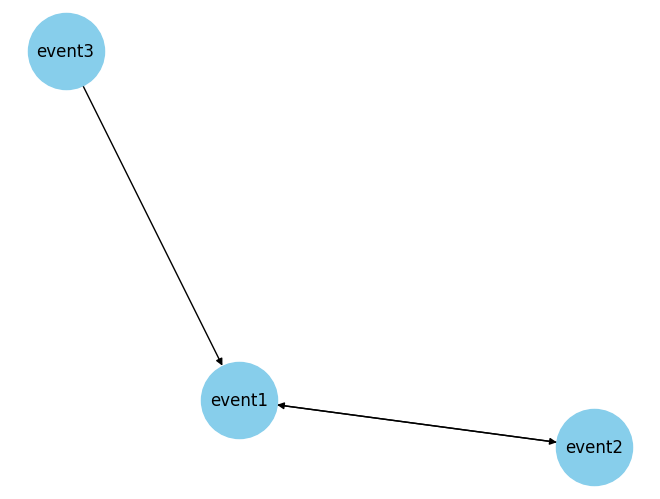

In [193]:
# Plot Graph
graph = nx.read_graphml(io.StringIO(data.loc[0, 'graph']))
nx.draw(graph, with_labels=True, node_size=3000, node_color='skyblue')
plt.show()

In [194]:
# Answer
print(data.loc[0, 'answer'])

True


# Prediction Presentation

TODO

In [149]:
import numpy as np
from src.utils.file import get_evaluation_file_path, get_data_file_path
import pandas as pd

data = pd.read_csv(get_evaluation_file_path(event_n=3, formula_n=3, count=300, model="qwen:32b-chat"))
data['answer'] = data['answer'].apply(lambda x: np.int64(1) if x == True else np.int64(0))
data['prediction'] = data['prediction'].astype(np.int64)
data

,context,query,question,code,formula,answer,graph,prediction,prediction_raw
0,"Initially, event3 happened. After event1, even...",C1: Event1 happens or event2 happens.\nC2: C1 ...,"=== Context ===\n\nInitially, event3 happened....","MODULE main\nVAR\n state : {event1, event2,...",(X ((event1 | event2) & event1)),1,"<graphml xmlns=""http://graphml.graphdrawing.or...",0,False
1,"Initially, event1 happened. After event3, no o...",C1: Event2 will happen eventually.\nC2: That e...,"=== Context ===\n\nInitially, event1 happened....","MODULE main\nVAR\n state : {event1, event2,...",(G (event2 -> (F event2))),1,"<graphml xmlns=""http://graphml.graphdrawing.or...",0,False
2,"Initially, event2 happened. After event2, even...",C1: Event3 will happen at next time.\nC2: Even...,"=== Context ===\n\nInitially, event2 happened....","MODULE main\nVAR\n state : {event1, event2,...",((X event3) -> (X event3)),1,"<graphml xmlns=""http://graphml.graphdrawing.or...",1,True
3,"Initially, event3 happened. After event1, even...",C1: Event2 happens and event3 happens.\nC2: Ev...,"=== Context ===\n\nInitially, event3 happened....","MODULE main\nVAR\n state : {event1, event2,...",(! (event1 | (event2 & event3))),1,"<graphml xmlns=""http://graphml.graphdrawing.or...",0,False
4,"Initially, event2 happened. After event1, even...",C1: Event3 happens or event3 happens.\nC2: C1 ...,"=== Context ===\n\nInitially, event2 happened....","MODULE main\nVAR\n state : {event1, event2,...",(! ((event3 | event3) | event1)),1,"<graphml xmlns=""http://graphml.graphdrawing.or...",0,False
...,...,...,...,...,...,...,...,...,...
295,"Initially, event3 happened. After event3, even...",C1: Event2 happens and event3 happens.\nC2: C1...,"=== Context ===\n\nInitially, event3 happened....","MODULE main\nVAR\n state : {event1, event2,...",(! (! (event2 & event3))),0,"<graphml xmlns=""http://graphml.graphdrawing.or...",1,True
296,"Initially, event1 happened. After event3, even...",C1: Event1 will happen eventually.\nC2: That C...,"=== Context ===\n\nInitially, event1 happened....","MODULE main\nVAR\n state : {event1, event2,...",(! ((F event1) -> event1)),0,"<graphml xmlns=""http://graphml.graphdrawing.or...",0,False
297,"Initially, event3 happened. After event3, even...",C1: Event2 happens and event1 happens.\nC2: Th...,"=== Context ===\n\nInitially, event3 happened....","MODULE main\nVAR\n state : {event1, event2,...",(! (event2 -> (event2 & event1))),0,"<graphml xmlns=""http://graphml.graphdrawing.or...",0,False
298,"Initially, event1 happened. After event1, even...",C1: That event3 happens implies that event1 ha...,"=== Context ===\n\nInitially, event1 happened....","MODULE main\nVAR\n state : {event1, event2,...",(F (! (event3 -> event1))),0,"<graphml xmlns=""http://graphml.graphdrawing.or...",1,True


In [150]:
len(data[data['answer'] == data['prediction']])

159

In [135]:
data['answer'].value_counts()

answer
1    51
0    49
Name: count, dtype: int64

In [103]:
print(data.loc[2, 'code'])

MODULE main
VAR
    state : {event1, event2, event3};
ASSIGN
    init(state) := event3;
    next(state) := case
        state = event3 : event1;
		state = event1 : event1;
		state = event2 : event2;
    esac;
LTLSPEC (X (state=event3))



In [151]:
print(data.loc[2, 'question'])

=== Context ===

Initially, event2 happened. After event2, event3 will happen. After event3, event1 will happen. After event3, event2 will happen. After event1, event2 will happen. After event1, event3 will happen.

=== Hypothesis ===

C1: Event3 will happen at next time.
C2: Event3 will happen at next time.
C3: That C1 holds implies that C2 holds.

C3 is True or False? Answer with "True" or "False" directly:



In [152]:
print(data.loc[2, 'answer'])

1


In [147]:
path = get_data_file_path(event_n=3, formula_n=3, count=300)
data = pd.read_csv(path)
data.head(10)

,context,query,question,code,formula,answer,graph
0,"Initially, event3 happened. After event1, even...",C1: Event1 happens or event2 happens.\nC2: C1 ...,"=== Context ===\n\nInitially, event3 happened....","MODULE main\nVAR\n state : {event1, event2,...",(X ((event1 | event2) & event1)),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
1,"Initially, event1 happened. After event3, no o...",C1: Event2 will happen eventually.\nC2: That e...,"=== Context ===\n\nInitially, event1 happened....","MODULE main\nVAR\n state : {event1, event2,...",(G (event2 -> (F event2))),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
2,"Initially, event2 happened. After event2, even...",C1: Event3 will happen at next time.\nC2: Even...,"=== Context ===\n\nInitially, event2 happened....","MODULE main\nVAR\n state : {event1, event2,...",((X event3) -> (X event3)),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
3,"Initially, event3 happened. After event1, even...",C1: Event2 happens and event3 happens.\nC2: Ev...,"=== Context ===\n\nInitially, event3 happened....","MODULE main\nVAR\n state : {event1, event2,...",(! (event1 | (event2 & event3))),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
4,"Initially, event2 happened. After event1, even...",C1: Event3 happens or event3 happens.\nC2: C1 ...,"=== Context ===\n\nInitially, event2 happened....","MODULE main\nVAR\n state : {event1, event2,...",(! ((event3 | event3) | event1)),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
5,"Initially, event2 happened. After event1, even...",C1: Event2 happens and event3 happens.\nC2: C1...,"=== Context ===\n\nInitially, event2 happened....","MODULE main\nVAR\n state : {event1, event2,...",(event1 -> ((event2 & event3) | event3)),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
6,"Initially, event2 happened. After event3, even...",C1: Event1 happens or event1 happens.\nC2: C1 ...,"=== Context ===\n\nInitially, event2 happened....","MODULE main\nVAR\n state : {event1, event2,...",(! ((event1 | event1) & event1)),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
7,"Initially, event3 happened. After event1, no o...",C1: Event2 happens or event2 happens.\nC2: C1 ...,"=== Context ===\n\nInitially, event3 happened....","MODULE main\nVAR\n state : {event1, event2,...",(! (G (event2 | event2))),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
8,"Initially, event3 happened. After event1, even...",C1: Event2 does not happen.\nC2: Event2 does n...,"=== Context ===\n\nInitially, event3 happened....","MODULE main\nVAR\n state : {event1, event2,...",((! event2) & (! event2)),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
9,"Initially, event3 happened. After event3, no o...",C1: Event3 will happen eventually.\nC2: C1 wil...,"=== Context ===\n\nInitially, event3 happened....","MODULE main\nVAR\n state : {event1, event2,...",(X (G (F event3))),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."


In [148]:
data['answer'].value_counts()

answer
True     150
False    150
Name: count, dtype: int64

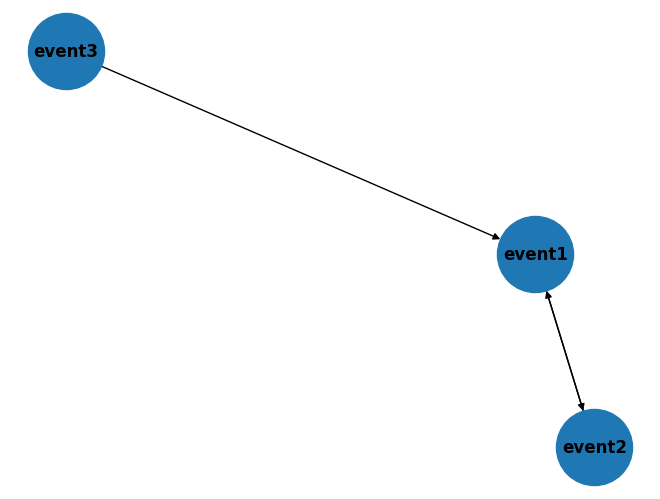

In [94]:
from matplotlib import pyplot as plt
import networkx as nx
import io

graph = nx.read_graphml(io.StringIO(data.loc[0, 'graph']))
nx.draw(graph, with_labels=True, font_weight='bold', node_size=3000)
plt.show()

In [95]:
print(data.loc[0, 'code'])


MODULE main
VAR
    state : {event1, event2, event3};
ASSIGN
    init(state) := event3;
    next(state) := case
        state = event1 : event2;
		state = event2 : event1;
		state = event3 : event1;
    esac;
LTLSPEC (X (((state=event1) | (state=event2)) & (state=event1)))



In [96]:
print(data.loc[0, 'question'])

=== Context ===

Initially, event3 happened. After event1, event2 will happen. After event2, event1 will happen. After event3, event1 will happen.

=== Hypothesis ===

C1: Event1 happens or event2 happens.
C2: C1 holds and event1 happens.
C3: C2 will happen at next time.

Determine whether the case C3 is true or false (answering in "true" or "false" directly):



In [97]:
print()

In [98]:
print("[np.str_('X'), [['event1', np.str_('|'), 'event2'], np.str_('&'), 'event1']]")

[np.str_('X'), [['event1', np.str_('|'), 'event2'], np.str_('&'), 'event1']]


In [116]:
import re

message = "True"
pattern = r'(true|false)'
result = re.search(pattern, message, flags=re.IGNORECASE)
result.group(0)

'True'